# Creating Hot Spot Maps

Local indicators of spatial association (LISAs) or hot spot maps is a common task used to explore spatial heterogeneity and locate areas of similar or dissimilar values.

In this notebook, it will be shown how to leverage PySAL and the Python API's Spatial Dataframe to visualize and calculate custom LISA cluster maps.

### Demo - Hotspots on Homicade Rates in 1990

**1).** Load the libraries and setup the notebook.

In [1]:
%matplotlib inline

In [2]:
from arcgis.gis import GIS
from arcgis.features import SpatialDataFrame
from arcgis.features import FeatureCollection
import numpy as np
import pysal as ps
import pandas as pd

**2).** PySAL has lots of built in datasets, the tutorial will leverage the 'NAT.shp' dataset.  

- Get the path to the dataset
- Display the dataset

In [3]:
fc = ps.examples.get_path('NAT.shp')

In [4]:
from arcgis.features import FeatureSet
sdf = SpatialDataFrame.from_featureclass(fc)
sdf.head()

,FID,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,FIPSNO,SOUTH,...,BLK90,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,SHAPE
0,0,Lake of the Woods,Minnesota,27,077,27077,27.0,77.0,27077.0,0,...,0.024534,0.285235,0.372336,0.342104,0.336455,11.279621,5.4,5.663881,9.515860,"{'rings': [[[-95.34258270263672, 48.5467033386..."
1,1,Ferry,Washington,53,019,53019,53.0,19.0,53019.0,0,...,0.317712,0.256158,0.360665,0.361928,0.360640,10.053476,2.6,10.079576,11.397059,"{'rings': [[[-118.85050201416016, 47.949687957..."
2,2,Stevens,Washington,53,065,53065,53.0,65.0,53065.0,0,...,0.210030,0.283999,0.394083,0.357566,0.369942,9.258437,5.6,6.812127,10.352015,"{'rings': [[[-117.43777465820312, 48.044219970..."
3,3,Okanogan,Washington,53,047,53047,53.0,47.0,53047.0,0,...,0.155922,0.258540,0.371218,0.381240,0.394519,9.039900,8.1,10.084926,12.840340,"{'rings': [[[-118.97096252441406, 47.939277648..."
4,4,Pend Oreille,Washington,53,051,53051,53.0,51.0,53051.0,0,...,0.134605,0.243263,0.365614,0.358706,0.387848,8.243930,4.1,7.557643,10.313002,"{'rings': [[[-117.4375, 48.999996185302734], [..."


In [5]:
sdf['SHAPE'] = sdf.geometry.project_as(4326)

In [24]:
gis = GIS()
m = gis.map('United States')
m

In [25]:
m.center = [42.877742, -97.380979]

In [26]:
m.zoom = 3

In [27]:
sdf.plot(kind='map', map_widget=m, 
         line_width=.75,
        outline_color='Greens_r')

True

**3).** Perform the LISA using PySAL


In [10]:
w = ps.weights.Queen.from_dataframe(sdf, geom_col='SHAPE')
hr90 = sdf['HR90']
lisa = ps.Moran_Local(hr90, w, permutations=9999)

**4).** Make some nice labels from the results and add it to the Spatial DataFrame 

In [11]:
lisa_lbls = {1: 'HH', 
             2: 'LH', 
             3: 'LL', 
             4: 'HL', 
             0: 'Non-significant'}
sign = lisa.p_sim < 0.05
quadS = lisa.q * sign
labels = pd.Series(quadS).map(lisa_lbls).values
sdf['LISALABELS'] = labels
sdf['LISAVALUES'] = pd.Series(quadS).values

### Examine the Results

As expected, most locations have no significant clustering, but we do have (dis)similarity within the dataset. 

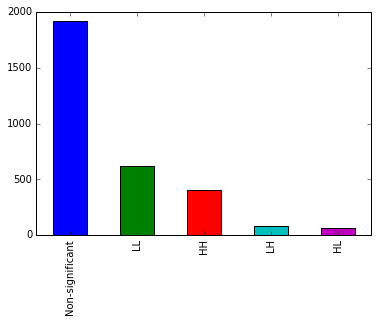

In [12]:
sdf.LISALABELS.value_counts().plot('bar')

**5). ** Showing the Results

Once the Spatial DataFrame is updated, it can be saved or displayed on a map. 

In [13]:
item = gis.content.search("id: 192a1923c2274af890645c5465184d35")[0]
item

<Item title:"1990 Homicide Map (Creating Using Python API)" type:Web Map owner:AndrewSolutions>

In [21]:
m = gis.map("United States")
m

In [19]:
m.zoom = 3

In [20]:
m.center = [42.877742, -97.380979]

In [22]:
q = sdf['LISALABELS'] == 'HH'
hh_sdf = sdf[q].copy()
hh_sdf.reset_index(inplace=True, drop=True)
hh_sdf.plot(map_widget=m, kind='map', line_width=.1,  pallette='Reds_r', alpha=.5)

True

In [23]:
q = sdf['LISALABELS'] == 'LL'
hh_sdf = sdf[q].copy()
hh_sdf.reset_index(inplace=True, drop=True)
hh_sdf.plot(map_widget=m, kind='map', line_width=.1,  pallette='Blues_r', alpha=.5)

True